<img src="https://ww2.ufps.edu.co/public/archivos/elementos_corporativos/logoufps.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
HYBRID MODEL BASED ON ARTIFICIAL INTELLIGENCE FOR ENERGY DISPATCH IN A MICROGRID</font>  

<font size='4'> Stacking technique Demand Notebook</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2023<br>
</font>

---

In [21]:
#Import libraries

import Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.serif'] = ['Times New Roman']
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

In [22]:
df = pd.read_csv('./3_Database.csv')
df = pd.DataFrame(df)
df = df.drop(['index'],axis=1)

df.loc[df['Produccion FV (MW)'] < 0, 'Produccion FV (MW)'] = 0
df.loc[df['Produccion Eolica (MW)'] < 0, 'Produccion Eolica (MW)'] = 0
df.loc[df['Demanda (MW)'] < 0, 'Demanda (MW)'] = 0

reduccion = [0.2,0.2,0.06]

df['Produccion FV (MW)'] = df['Produccion FV (MW)']*reduccion[0]
df['Produccion Eolica (MW)'] = df['Produccion Eolica (MW)']*reduccion[1]
df['Demanda (MW)'] = df['Demanda (MW)']*reduccion[2]

df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-T%H:%M')
df= df.set_index('Time')
df= df.asfreq('5min')
df= df.sort_index()

fin_validacion = '2021-09-13 00:00'
df  = df.loc[fin_validacion:, :]


In [23]:
XGB_model = pd.read_csv('./Predictions/Demand/XGB_predictions.csv')
LR_model = pd.read_csv('./Predictions/Demand/LR_predictions.csv')
DT_model = pd.read_csv('./Predictions/Demand/DT_predictions.csv')

XGB_model = pd.DataFrame(XGB_model)
LR_model = pd.DataFrame(LR_model)
DT_model = pd.DataFrame(DT_model)

XGB_model['Time'] = pd.to_datetime(XGB_model['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
XGB_model= XGB_model.set_index('Time')
XGB_model= XGB_model.asfreq('5min')
XGB_model= XGB_model.sort_index()

LR_model['Time'] = pd.to_datetime(LR_model['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
LR_model= LR_model.set_index('Time')
LR_model= LR_model.asfreq('5min')
LR_model= LR_model.sort_index()

DT_model['Time'] = pd.to_datetime(DT_model['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
DT_model= DT_model.set_index('Time')
DT_model= DT_model.asfreq('5min')
DT_model= DT_model.sort_index()

XGB_model = XGB_model.rename(columns={'pred':'XGB_pred'})
LR_model = LR_model.rename(columns={'pred':'LR_pred'})
DT_model = DT_model.rename(columns={'pred':'DT_pred'})

XGB_model.loc[XGB_model['XGB_pred'] < 0, 'XGB_pred'] = 0
LR_model.loc[LR_model['LR_pred'] < 0, 'LR_pred'] = 0
DT_model.loc[DT_model['DT_pred'] < 0, 'DT_pred'] = 0

XGB_model = XGB_model['XGB_pred']
LR_model = LR_model['LR_pred']
DT_model = DT_model['DT_pred']


In [24]:
train = pd.concat([XGB_model, LR_model, DT_model, df['Demanda (MW)']], axis=1)
test = train.loc['2021-12-01 00:00':, :]
train = train.drop(test.index)

X_train = train[['XGB_pred', 'LR_pred', 'DT_pred']]
y_train = train['Demanda (MW)']
X_test = test[['XGB_pred', 'LR_pred', 'DT_pred']]
y_test = test['Demanda (MW)']

X_train_stacked = pd.DataFrame({'XGB_pred': X_train['XGB_pred'], 
                                'LR_pred': X_train['LR_pred'],
                                'DT_pred': X_train['DT_pred']})
y_train_stacked = y_train

xgb = XGBRegressor(n_estimators=70)
#xgb = LinearRegression()
#xgb = DecisionTreeRegressor()
modelo_stacked = AdaBoostRegressor(estimator=xgb, n_estimators=50, learning_rate=0.1).fit(X_train_stacked, y_train_stacked)

predicciones_stacked = modelo_stacked.predict(pd.DataFrame({'XGB_pred': X_test['XGB_pred'], 'LR_pred': X_test['LR_pred'], 'DT_pred': X_test['DT_pred']}))

resultados = pd.DataFrame({'XGB_pred': X_test['XGB_pred'], 'LR_pred': X_test['LR_pred'], 'DT_pred': X_test['DT_pred'], 'predicciones_stacked': predicciones_stacked, 'Demanda (MW)': y_test})
resultados.loc[resultados['predicciones_stacked'] < 0, 'predicciones_stacked'] = 0


In [25]:
inicio = '2021-12-01 00:00'
final =  '2021-12-01 23:55'

In [26]:
#Markers

marker1 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Valores reales", color="blue")
marker2 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Predicciones", color="green")

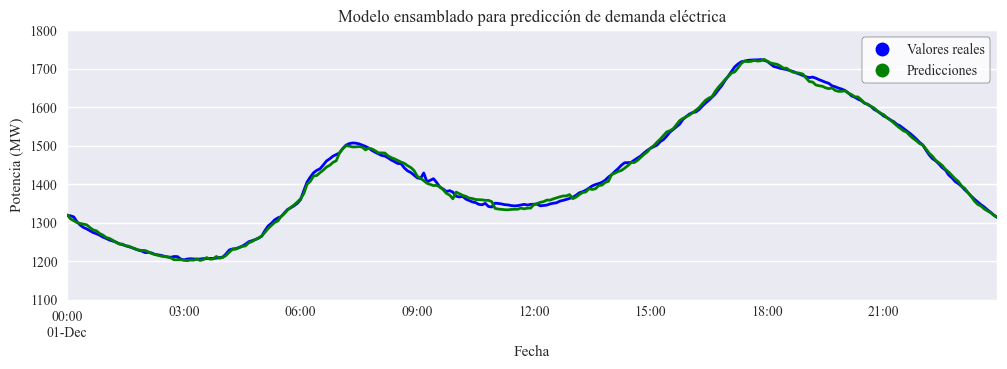

In [27]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[df.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Real value', color='blue')
#resultados['XGB_pred'].plot(linewidth=2, label='XGB_pred', ax=ax, color='green')
#resultados['LR_pred'].plot(linewidth=2, label='LR_pred', ax=ax, color='red')
resultados['predicciones_stacked'].plot(linewidth=2, label='Stacked_pred', ax=ax, color='green')
ax.set_ylim(1100,1800)
ax.set_ylabel("Potencia (MW)")
ax.set_xlabel("Fecha")
ax.set_title("Modelo ensamblado para predicción de demanda eléctrica")
ax.set_xlim(inicio,final)
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
fig.savefig('./Plots/Ensemble/Demand.svg',bbox_inches='tight')

In [28]:
import numpy as np

def MAPE(prediction,true_value):
    return np.mean(
        np.abs(
            (prediction-true_value)/true_value
            )*100
        )
def calculate_mape(predicted, real, data, data2):
    percentage = []
    for i in range(0,len(predicted)):
        if int(real.iloc[i][data]) != 0:
            percentage.append(MAPE(float(predicted.iloc[i][data2]),float(real.iloc[i][data])))
        else:
            percentage.append(0)
    predicted['MAPE'] = percentage

    avg = np.mean(predicted['MAPE'], axis=0)
    return avg

In [29]:
mape=calculate_mape(resultados,resultados,'Demanda (MW)','predicciones_stacked')
print(f'MAPE Stacked: {mape} %')
mape=calculate_mape(resultados,resultados,'Demanda (MW)','XGB_pred')
print(f'MAPE XGB: {mape} %')
mape=calculate_mape(resultados,resultados,'Demanda (MW)','LR_pred')
print(f'MAPE LR: {mape} %')
mape=calculate_mape(resultados,resultados,'Demanda (MW)','DT_pred')
print(f'MAPE DT: {mape} %')

MAPE Stacked: 0.519926862643319 %
MAPE XGB: 0.6813595923203536 %
MAPE LR: 0.4910845259665159 %
MAPE DT: 2.1571626010957266 %


In [30]:
resultados.to_csv('6b_Predictions_Demand.csv')